# Test a meta-reinforcement learning model (A2C) on an associative learning task

## What is meta-reinforcement learning?

TODO: explain meta-reinforcement learning

### Let's setup the environment

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-dark-palette')
mpl.rcParams['axes.titlesize'] = 20

## What is the two step task, and why should I care?

P1: explain model-free and model-based behavior in cognitive science

P2: two-step task is an iconic experiment demonstrating that humans have the ability to learn in a model-based manner.

P3: add maybe a figure to explain how the two-step task should work.

## Finally, let's train the model

In [ ]:
from envs.GuessBoundary import GuessBoundaryTask
from utils.utils import do_experiment

# specify the agent and the environment
num_lstm_units = 30
num_train_steps = 20_000_000
policy_kwargs = {'n_lstm': num_lstm_units, 'action_noise': 0}
env = GuessBoundaryTask(obs_mode='all_history')

do_experiment(env, num_train_steps, policy_kwargs)

In [ ]:
from envs.Collins2018 import Collins2018Task
from utils.utils import do_experiment

# specify the agent and the environment
num_lstm_units = 20
num_train_steps = 30_000
policy_kwargs = {'n_lstm': num_lstm_units, 'action_noise': 0}
env = Collins2018Task(num_objects=(3, 6), num_actions=3, num_repeats=13)

do_experiment(env, num_train_steps, policy_kwargs)

## Let's visualize the model performance

In [2]:
from utils.utils import Simulation
from envs.GuessBoundary import GuessBoundaryTask
from envs.Collins2018 import Collins2018Task

env = Collins2018Task(num_objects=(1, 2, 3, 4, 5, 6))

sims = [Simulation('./outputs/Collins2018/A2C-LSTM20', env)]
sims[0].evaluate(num_test_episodes=600, num_trials=100, verbose=True)

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/

invalid load_params_file_idx. Loading parameters from the latest save file.
reward per episode is 36.95 ± 17.79
average episode length is  44.915


## Monitor training progress

,index,r,l,t,l_moving_avg_100,r_moving_avg_100,t_per_M
0,0,26,79,10.132764,NaN,NaN,0.010133
1,1,18,40,10.173673,NaN,NaN,0.010174
2,2,29,79,10.250985,NaN,NaN,0.010251
3,3,19,79,10.327234,NaN,NaN,0.010327
4,4,28,79,10.403021,NaN,NaN,0.010403
...,...,...,...,...,...,...,...
414,414,22,79,32.063507,57.16,19.21,0.032064
415,415,26,79,32.132212,57.16,19.24,0.032132
416,416,27,79,32.201226,57.55,19.39,0.032201
417,417,19,79,32.269356,57.94,19.42,0.032269


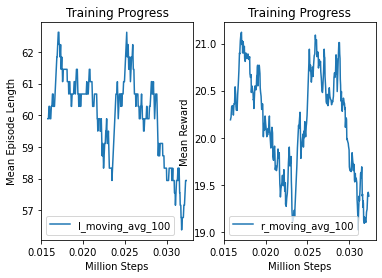

In [17]:
from utils.visualization import plot_training_progress

plot_training_progress(sims[0].model_path)

## Some visualizations specific to Collins 2018 task

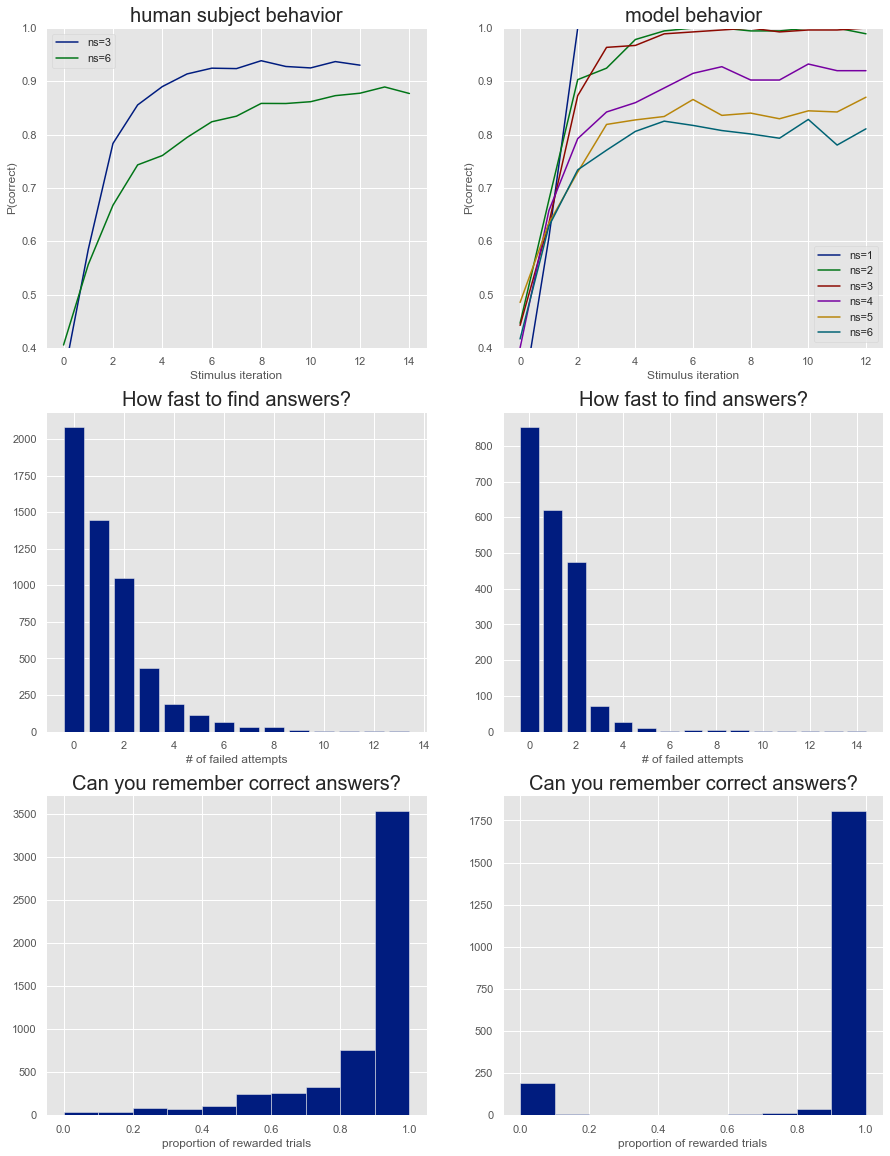

In [15]:
from utils.visualization import plot_associative_learning_progress, calc_exploration_and_retention
from utils.utils import behav2sim

df_behav = behav2sim()
df_model = sims[0].rollouts
dfs = [df_behav, df_model]

fig, axs = plt.subplots(3, len(dfs), figsize=(15, 20))
axs[0, 0].set_title('human subject behavior')
axs[0, 1].set_title('model behavior', )
for mdl in range(len(dfs)):
    # does the model learn after multiple stimulus presentations?
    plot_associative_learning_progress(axs[0, mdl], dfs[mdl])

    # does the model learn to attempt different actions after failed trials (before the single success)? 
    calc_exploration_and_retention([axs[1, mdl], axs[2, mdl]], dfs[mdl])
    

# insight: network should be quite larger than the optimal size

Note the small bump at 0 in the bottom right graph. What does this mean?

This means that the trained model has a noticeable chance to completely forget the answer for an object, and this indicates imperfect memory retention.

### Do we observe any artifacts unique to the models?

Yes. Since the objects are coded 0-2 and 0-5 in the 3- and 6-object tasks respectively, the model may be trained more on the first three objects and less the last three. On the other hand, humans subjects might show similar trends since their working memory is already pre-occupied by earlier objects, but the effect shouldn't but huge.

Here is the comparison between the human behavior and the model:

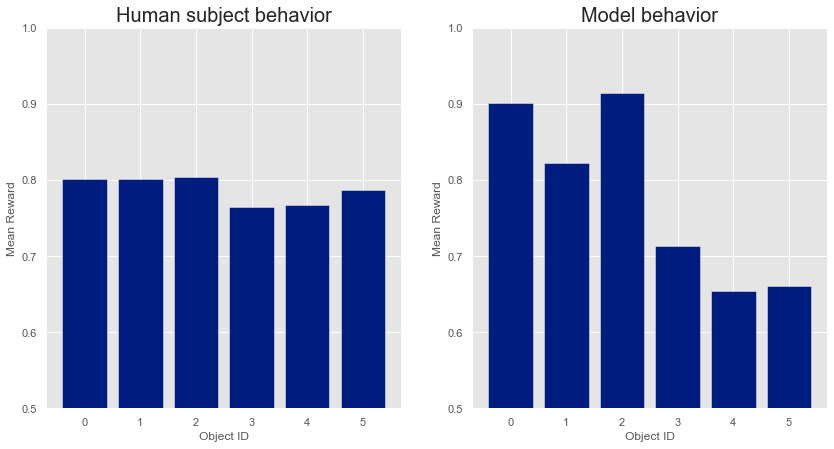

In [16]:
# is there training artifact that the stimulus 0-2 are better trained?
# Ans: yes
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

obj_rewards = df_behav.groupby('observations').rewards.mean().tolist()
axs[0].bar(np.arange(len(obj_rewards)), obj_rewards)
axs[0].set_title('Human subject behavior')

obj_rewards = df_model.groupby('observations').rewards.mean().tolist()
axs[1].bar(np.arange(len(obj_rewards)), obj_rewards)
axs[1].set_title('Model behavior')

for i in range(2):
    axs[i].set_xlabel('Object ID')
    axs[i].set_ylabel('Mean Reward')
    axs[i].set_ylim([0.5, 1])

## Obsolete: This visualizes the two-step task

In [ ]:
from stable_baselines.common.cmd_util import make_vec_env

from utils.utils import Simulation
from utils.visualization import plot_best_action_reversal, calc_stay_prob, plot_stay_prob, visualize_hidden_units
from envs.TwoStepTask import TwoStepTask
from envs.GuessBoundary import GuessBoundaryTask

env = TwoStepTask(prob_switch_reward=0.05, num_trials=200)
env = make_vec_env(lambda: env, n_envs=1)

sims = [Simulation('./outputs/A2C-LSTM10_Standard_PSwitch5e-2/train25000', env = env),
              Simulation('./outputs/A2C-LSTM10_Standard_PSwitch5e-2/train500000', env = env)]
            
fig, axs = plt.subplots(3, len(sims), figsize = (16, 16))
fig.suptitle('Training Steps: 25K / 500K', fontsize=30)
for ctr, sim in enumerate(sims):
    sim.evaluate()
    
    # first row: how fast can the model switch behaviors after a switch
    plotActionReversal(axs[0, ctr], sim.TestRollouts)
    
    # second row: MB or MF behavior?
    stayProb, _, _ = calcStayProb(sim.TestRollouts)
    plotStayProb(axs[1, ctr], stayProb)
    
    # third row: try to visualize the hidden units
    vis = visualizeH(axs[2, ctr], sim.TestRollouts)